In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pointscat.forward_problem import angle_to_vec, PointScatteringProblem
from pointscat.inverse_problem import unif_sample_disk, DiscreteMeasure, solve_blasso


np.random.seed(0)

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['+Computer Modern'],
    'font.size': 20,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# First experiment

In [2]:
# setting problem
box_size = 10/2  # locations should belong to (-box_size/2,box_size/2)
amplitudes = np.array([1.2, 2.3, 1.9])
locations = np.array([[-1.0, 3.7], [-4.0, 0.0], [4.2, 2.6]]) / 4
wave_number = 1
point_scat = PointScatteringProblem(locations, amplitudes, wave_number)
measure = DiscreteMeasure(locations, amplitudes)

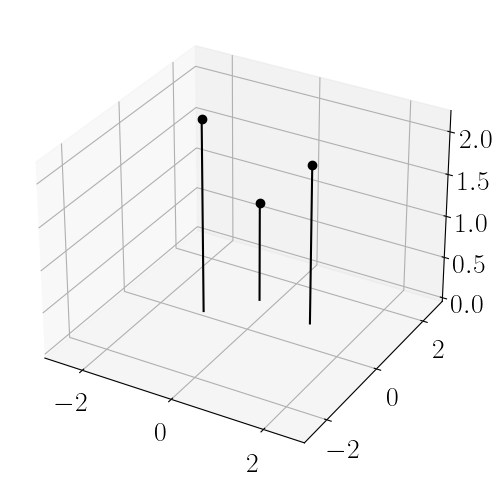

In [3]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1, projection='3d')

markerline, stemlines, baseline = ax.stem(locations[:, 0], locations[:, 1], amplitudes, label='unknown')

stemlines.set_color('black')
markerline.set_color('black')
baseline.set_linestyle('none')

ax.set_xlim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_ylim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_zlim(0, 2.2)

plt.show()
# plt.savefig('meas_1.png', bbox_inches='tight', transparent=True, dpi=300);

In [4]:
# far field computation
num_frequencies = 30
cutoff_frequency = 2 * wave_number
frequencies = unif_sample_disk(num_frequencies, cutoff_frequency)

incident_angles = np.array([np.pi + np.angle(k[0]+1j*k[1]) - np.arccos(np.linalg.norm(k)/(2*wave_number))
                            for k in frequencies])
observation_directions = np.array([np.angle(k[0]+1j*k[1]) + np.arccos(np.linalg.norm(k)/(2*wave_number))
                                   for k in frequencies])

far_field = point_scat.compute_far_field(incident_angles, observation_directions)
far_field_born = point_scat.compute_far_field(incident_angles, observation_directions, born_approx=True)

In [5]:
# observations
obs = np.concatenate([np.real(far_field), -np.imag(far_field)])
born_obs = np.concatenate([np.real(far_field_born), -np.imag(far_field_born)])

print("relative L2 error between true far field and Born approximation:")
print(np.linalg.norm(obs - born_obs) / np.linalg.norm(obs))

print("absolute L2 error between true far field and Born approximation:")
print(np.linalg.norm(obs - born_obs))

std_noise = 0.2
noise = np.random.normal(scale=std_noise, size=obs.shape)
noisy_obs = obs + noise
print("noise level")
print(np.linalg.norm(noise) / np.linalg.norm(obs))

relative L2 error between true far field and Born approximation:
0.4723380050817709
absolute L2 error between true far field and Born approximation:
7.835948866058696
noise level
0.09125932223299102


In [6]:
# parameters
reg_param = 1.0
tol_locations = 0.05
tol_amplitudes = 0.01

In [7]:
# computation of the BLASSO estimator under Born approx

num_iter = 10

print("computation of the BLASSO estimator under Born approx...")
estimated_measure = solve_blasso(frequencies, noisy_obs, reg_param, num_iter, box_size,
                                 tol_locations=tol_locations, tol_amplitudes=tol_amplitudes)

computation of the BLASSO estimator under Born approx...


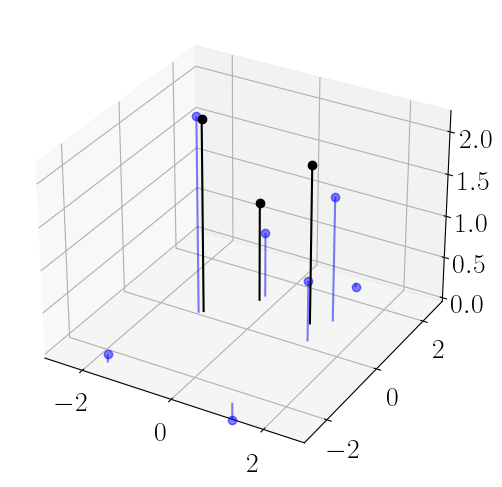

In [8]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1, projection='3d')

markerline, stemlines, baseline = ax.stem(estimated_measure.locations[:, 0],
                                          estimated_measure.locations[:, 1],
                                          estimated_measure.amplitudes,
                                          label='estimated')

stemlines.set_color('blue')
stemlines.set_alpha(0.5)
markerline.set_color('blue')
markerline.set_alpha(0.5)
baseline.set_linestyle('none')

markerline, stemlines, baseline = ax.stem(locations[:, 0], locations[:, 1], amplitudes, label='unknown')

stemlines.set_color('black')
markerline.set_color('black')
baseline.set_linestyle('none')

ax.set_xlim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_ylim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_zlim(0, 2.2)

plt.show();
# plt.savefig('lin_est_1.png', bbox_inches='tight', transparent=True, dpi=300)

In [9]:
print("nonlinear sliding...")
state = estimated_measure.perform_nonlinear_sliding(incident_angles, observation_directions,
                                                    noisy_obs, wave_number,
                                                    box_size, reg_param=reg_param,
                                                    tol_locations=tol_locations,
                                                    tol_amplitudes=tol_amplitudes);

nonlinear sliding...


In [10]:
print("estimated amplitudes:")
print(estimated_measure.amplitudes)

print("estimated locations:")
print(estimated_measure.locations)

estimated amplitudes:
[2.19742746 1.83171463 1.10009994]
estimated locations:
[[-1.01081413 -0.01014197]
 [ 1.06584386  0.64978458]
 [-0.27292886  0.94156328]]


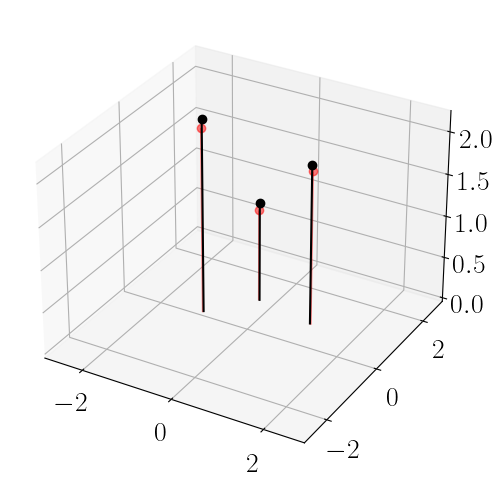

In [11]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1, projection='3d')

markerline, stemlines, baseline = ax.stem(estimated_measure.locations[:, 0],
                                          estimated_measure.locations[:, 1],
                                          estimated_measure.amplitudes)

stemlines.set_color('red')
stemlines.set_alpha(0.5)
markerline.set_color('red')
markerline.set_alpha(0.5)
baseline.set_linestyle('none')

markerline, stemlines, baseline = ax.stem(locations[:, 0], locations[:, 1], amplitudes)

stemlines.set_color('black')
markerline.set_color('black')
baseline.set_linestyle('none')

ax.set_xlim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_ylim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_zlim(0, 2.2)

plt.show()
# plt.savefig('nonlin_est_1.png', bbox_inches='tight', transparent=True, dpi=300)

# Second experiment

In [ ]:
# setting problem
box_size = 10/2  # locations should belong to (-box_size/2,box_size/2)
amplitudes = np.array([0.8, 1.3, 0.9])
locations = np.array([[-4.0, 3.2], [-4.0, -4.5], [4.2, 4.1]]) / 3
wave_number = 1
point_scat = PointScatteringProblem(locations, amplitudes, wave_number)
measure = DiscreteMeasure(locations, amplitudes)

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1, projection='3d')

markerline, stemlines, baseline = ax.stem(locations[:, 0], locations[:, 1], amplitudes, label='unknown')

stemlines.set_color('black')
markerline.set_color('black')
baseline.set_linestyle('none')

ax.set_xlim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_ylim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_zlim(0, 2.2)

plt.savefig('meas_2.png', bbox_inches='tight', transparent=True, dpi=300);

In [ ]:
# far field computation
num_frequencies = 20
cutoff_frequency = 2 * wave_number
frequencies = unif_sample_disk(num_frequencies, cutoff_frequency)

incident_angles = np.array([np.pi + np.angle(k[0]+1j*k[1]) - np.arccos(np.linalg.norm(k)/(2*wave_number))
                            for k in frequencies])
observation_directions = np.array([np.angle(k[0]+1j*k[1]) + np.arccos(np.linalg.norm(k)/(2*wave_number))
                                   for k in frequencies])

far_field = point_scat.compute_far_field(incident_angles, observation_directions)
far_field_born = point_scat.compute_far_field(incident_angles, observation_directions, born_approx=True)

In [ ]:
# observations
obs = np.concatenate([np.real(far_field), -np.imag(far_field)])
born_obs = np.concatenate([np.real(far_field_born), -np.imag(far_field_born)])
print("relative L2 error between true far field and Born approximation:")
print(np.linalg.norm(obs - born_obs) / np.linalg.norm(born_obs))

std_noise = 0.2
noise = np.random.normal(scale=std_noise, size=obs.shape)
noisy_obs = obs + noise
print("noise level")
print(np.linalg.norm(noise) / np.linalg.norm(obs))

In [ ]:
# parameters
reg_param = 1.5
tol_locations = 0.1
tol_amplitudes = 0.01

In [ ]:
# computation of the BLASSO estimator under Born approx

num_iter = 10

print("computation of the BLASSO estimator under Born approx...")
estimated_measure = solve_blasso(frequencies, noisy_obs, reg_param, num_iter, box_size,
                                 tol_locations=tol_locations, tol_amplitudes=tol_amplitudes)

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1, projection='3d')

markerline, stemlines, baseline = ax.stem(estimated_measure.locations[:, 0],
                                          estimated_measure.locations[:, 1],
                                          estimated_measure.amplitudes,
                                          label='estimated')

stemlines.set_color('blue')
stemlines.set_alpha(0.5)
markerline.set_color('blue')
markerline.set_alpha(0.5)
baseline.set_linestyle('none')

markerline, stemlines, baseline = ax.stem(locations[:, 0], locations[:, 1], amplitudes, label='unknown')

stemlines.set_color('black')
markerline.set_color('black')
baseline.set_linestyle('none')

ax.set_xlim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_ylim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_zlim(0, 2.2)
plt.savefig('lin_est_2.png', bbox_inches='tight', transparent=True, dpi=300);

In [ ]:
print("nonlinear sliding...")
estimated_measure.perform_nonlinear_sliding(incident_angles, observation_directions, noisy_obs, wave_number, 
                                            box_size, reg_param=reg_param, 
                                            tol_locations=tol_locations, tol_amplitudes=tol_amplitudes);

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1, projection='3d')

markerline, stemlines, baseline = ax.stem(estimated_measure.locations[:, 0],
                                          estimated_measure.locations[:, 1],
                                          estimated_measure.amplitudes)

stemlines.set_color('red')
stemlines.set_alpha(0.5)
markerline.set_color('red')
markerline.set_alpha(0.5)
baseline.set_linestyle('none')

markerline, stemlines, baseline = ax.stem(locations[:, 0], locations[:, 1], amplitudes)

stemlines.set_color('black')
markerline.set_color('black')
baseline.set_linestyle('none')

ax.set_xlim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_ylim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_zlim(0, 2.2)

plt.savefig('nonlin_est_2.png', bbox_inches='tight', transparent=True, dpi=300);

# Third experiment

In [ ]:
# setting problem
box_size = 10  # locations should belong to (-box_size/2,box_size/2)
amplitudes = 0.5 * np.array([1, 2, 1, 0.5, 3, 1, 0.6, 2, 0.8])
locations = np.array([[-4.3, -4.7], [-4.0, 4.5], [4.2, 3.6], [0.1, 0.1], [2.5, 2.1], [-1.2, 3.4],
                      [-1/0.4, 1/0.4], [1/0.4, -1/0.4], [-1, -2]])
wave_number = 1
point_scat = PointScatteringProblem(locations, amplitudes, wave_number)
measure = DiscreteMeasure(locations, amplitudes)

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1, projection='3d')

markerline, stemlines, baseline = ax.stem(locations[:, 0], locations[:, 1], amplitudes, label='unknown')

stemlines.set_color('black')
markerline.set_color('black')
baseline.set_linestyle('none')

ax.set_xlim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_ylim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_zlim(0, 2.2)

plt.savefig('meas_3.png', bbox_inches='tight', transparent=True, dpi=300);

In [ ]:
# far field computation
num_frequencies = 100
cutoff_frequency = 2 * wave_number
frequencies = unif_sample_disk(num_frequencies, cutoff_frequency)

incident_angles = np.array([np.pi + np.angle(k[0]+1j*k[1]) - np.arccos(np.linalg.norm(k)/(2*wave_number))
                            for k in frequencies])
observation_directions = np.array([np.angle(k[0]+1j*k[1]) + np.arccos(np.linalg.norm(k)/(2*wave_number))
                                   for k in frequencies])

far_field = point_scat.compute_far_field(incident_angles, observation_directions)
far_field_born = point_scat.compute_far_field(incident_angles, observation_directions, born_approx=True)

In [ ]:
# observations
obs = np.concatenate([np.real(far_field), -np.imag(far_field)])
born_obs = np.concatenate([np.real(far_field_born), -np.imag(far_field_born)])
print("relative L2 error between true far field and Born approximation:")
print(np.linalg.norm(obs - born_obs) / np.linalg.norm(born_obs))

std_noise = 0.1
noise = np.random.normal(scale=std_noise, size=obs.shape)
noisy_obs = obs + noise
print("noise level")
print(np.linalg.norm(noise) / np.linalg.norm(obs))

In [ ]:
# parameters
reg_param = 10.0
tol_locations = 0.1
tol_amplitudes = 0.01

In [ ]:
# computation of the BLASSO estimator under Born approx

num_iter = 20

print("computation of the BLASSO estimator under Born approx...")
estimated_measure = solve_blasso(frequencies, noisy_obs, reg_param, num_iter, box_size,
                                 tol_locations=tol_locations, tol_amplitudes=tol_amplitudes)

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1, projection='3d')

markerline, stemlines, baseline = ax.stem(estimated_measure.locations[:, 0],
                                          estimated_measure.locations[:, 1],
                                          estimated_measure.amplitudes,
                                          label='estimated')

stemlines.set_color('blue')
stemlines.set_alpha(0.5)
markerline.set_color('blue')
markerline.set_alpha(0.5)
baseline.set_linestyle('none')

markerline, stemlines, baseline = ax.stem(locations[:, 0], locations[:, 1], amplitudes, label='unknown')

stemlines.set_color('black')
markerline.set_color('black')
baseline.set_linestyle('none')

ax.set_xlim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_ylim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_zlim(0, 2.2)
plt.savefig('lin_est_3.png', bbox_inches='tight', transparent=True, dpi=300);

In [ ]:
print("nonlinear sliding...")
estimated_measure.perform_nonlinear_sliding(incident_angles, observation_directions, noisy_obs, wave_number, 
                                            box_size, reg_param=reg_param, 
                                            tol_locations=tol_locations, tol_amplitudes=tol_amplitudes);

In [ ]:
fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(1, 1, 1, projection='3d')

markerline, stemlines, baseline = ax.stem(estimated_measure.locations[:, 0],
                                          estimated_measure.locations[:, 1],
                                          estimated_measure.amplitudes)

stemlines.set_color('red')
stemlines.set_alpha(0.5)
markerline.set_color('red')
markerline.set_alpha(0.5)
baseline.set_linestyle('none')

markerline, stemlines, baseline = ax.stem(locations[:, 0], locations[:, 1], amplitudes)

stemlines.set_color('black')
markerline.set_color('black')
baseline.set_linestyle('none')

ax.set_xlim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_ylim(-1.1*box_size/2, 1.1*box_size/2)
ax.set_zlim(0, 2.2)

plt.savefig('nonlin_est_3.png', bbox_inches='tight', transparent=True, dpi=300);